# Project: Sales Analysis

## Importing different libraries used in the project

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

## Reading and displaying the features of the sales dataset

In [2]:
df = pd.read_csv('AusApparalSales4thQrt2020.csv', parse_dates=['Date']) # parse_dates argument ensures correct data typing on Date column
print(df.head(),"\n")
df.info()

        Date        Time State     Group  Unit  Sales
0 2020-10-01     Morning    WA      Kids     8  20000
1 2020-10-01     Morning    WA       Men     8  20000
2 2020-10-01     Morning    WA     Women     4  10000
3 2020-10-01     Morning    WA   Seniors    15  37500
4 2020-10-01   Afternoon    WA      Kids     3   7500 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7560 entries, 0 to 7559
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7560 non-null   datetime64[ns]
 1   Time    7560 non-null   object        
 2   State   7560 non-null   object        
 3   Group   7560 non-null   object        
 4   Unit    7560 non-null   int64         
 5   Sales   7560 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 354.5+ KB


## Data wrangling

### Part 1: Checking for nulls and data normalization

In [3]:
cols_with_nas = 0
df_orig = df.copy()
for col in df.columns:
    if(df.isna().sum()[col] != 0):
        cols_with_nas += 1
print(len(df.columns),"columns found in dataset.",cols_with_nas," columns contain nulls")
if(not cols_with_nas):
    print("No nulls found. Additional treatment not required for the dataset")
  
# apply normalization techniques 
columns = ['Unit','Sales']
for col in columns:
    df[col] = MinMaxScaler().fit_transform(np.array(df[col]).reshape(-1,1)) 
df.head()


6 columns found in dataset. 0  columns contain nulls
No nulls found. Additional treatment not required for the dataset


,Date,Time,State,Group,Unit,Sales
0,2020-10-01,Morning,WA,Kids,0.095238,0.095238
1,2020-10-01,Morning,WA,Men,0.095238,0.095238
2,2020-10-01,Morning,WA,Women,0.031746,0.031746
3,2020-10-01,Morning,WA,Seniors,0.206349,0.206349
4,2020-10-01,Afternoon,WA,Kids,0.015873,0.015873


### Part 2 - Dropping duplicate columns and performing groupby required for data analysis

On checking the table, we find that the column Sales is exactly same as Unit after normalization.
I have chosen to drop Unit column and will be using Sales column to perform all statistical analysis.

First we need to confirm that the data is same for all rows and there are no inconsistencies.
We cannot use == operator as floating point operations are not precise and there are minor differences in Unit and Sales after normalization.
We ensure that the difference is less than 1e-15 which is negligible quantity as shown below

In [4]:
print(False in abs(df['Unit']-df['Sales'] < 1e-15))

False


The above logical check implies that the difference between the quantities is negligible and one column can be dropped. Since it makes sense to talk of sales figures in actual numbers rather than using normalized data, we use the original sales column

In [5]:
df = df.drop(columns=['Unit','Sales'], axis=1)
df['Sales']=df_orig['Sales']
df.head()

,Date,Time,State,Group,Sales
0,2020-10-01,Morning,WA,Kids,20000
1,2020-10-01,Morning,WA,Men,20000
2,2020-10-01,Morning,WA,Women,10000
3,2020-10-01,Morning,WA,Seniors,37500
4,2020-10-01,Afternoon,WA,Kids,7500


## Data analysis

In [6]:
df.set_index(['Date'], inplace=True, drop=True)
df.head()

,Time,State,Group,Sales
Date,,,,
2020-10-01,Morning,WA,Kids,20000
2020-10-01,Morning,WA,Men,20000
2020-10-01,Morning,WA,Women,10000
2020-10-01,Morning,WA,Seniors,37500
2020-10-01,Afternoon,WA,Kids,7500


##### We are now performing weekly, monthly and quarterly analyis of sales data. The following points will be captured.

1. Average daily sales (avg_daily_sales)
2. Group generating highest sales (group_hs)
3. Group generating lowest sales (group_ls)
4. State generating highest sales (state_hs)
5. State generating lowest sales (state_ls)

### Generating required tables for analysis

In [7]:
# Weekly statistics

print("Number of days in the dataset ",(df.index.unique()[-1] - df.index.unique()[0]).days)
print("\nSales analysis for each week of Q4\n")

start_dates = list(df.index.unique()[0::7])
end_dates = list(df.index.unique()[6::7])

# There are 90 days of data in the data set which is not a integer multiple of 7. Hence, one entry will be missing in end_dates which can be added as follows
end_dates.append(df.index[-1])

wk_table = {
    'week':[],
    'avg_daily_sales':[],
    'group_hs':[],
    'group_ls':[],
    'state_hs':[],
    'state_ls':[]
}
df_wk_lst = []  # This list stores the dataframe for each week needed during visualization

for i in range(0,len(start_dates)):
    df_wk = df.loc[start_dates[i]:end_dates[i]]
    df_wk_lst.append(df_wk)
    wk_table['week'].append(i+1)
    wk_table['avg_daily_sales'].append(df_wk.groupby(['Group'])['Sales'].sum().sum()/7)
    wk_table['group_hs'].append(df_wk.groupby(['Group'])['Sales'].sum().idxmax())
    wk_table['group_ls'].append(df_wk.groupby(['Group'])['Sales'].sum().idxmin())
    wk_table['state_hs'].append(df_wk.groupby(['State'])['Sales'].sum().idxmax())
    wk_table['state_ls'].append(df_wk.groupby(['State'])['Sales'].sum().idxmin())
wk_stats = pd.DataFrame(wk_table)
wk_stats.set_index(['week'], inplace=True, drop=True)
print(wk_stats)

# Monthly statistics

print("\nSales analysis for each month of Q4\n")

start_dates = list(df.index.unique()[0::30])
end_dates = list(df.index.unique()[29::30])

mn_table = {
    'month':[],
    'avg_daily_sales':[],
    'group_hs':[],
    'group_ls':[],
    'state_hs':[],
    'state_ls':[]
}
df_mn_lst = []  # This list stores the dataframe for each week needed during visualization
for i in range(0,len(start_dates)):
    df_mn = df.loc[start_dates[i]:end_dates[i]]
    df_mn_lst.append(df_mn)
    mn_table['month'].append(i+1)
    mn_table['avg_daily_sales'].append(df_mn.groupby(['Group'])['Sales'].sum().sum()/30)
    mn_table['group_hs'].append(df_mn.groupby(['Group'])['Sales'].sum().idxmax())
    mn_table['group_ls'].append(df_mn.groupby(['Group'])['Sales'].sum().idxmin())
    mn_table['state_hs'].append(df_mn.groupby(['State'])['Sales'].sum().idxmax())
    mn_table['state_ls'].append(df_mn.groupby(['State'])['Sales'].sum().idxmin())
mn_stats = pd.DataFrame(mn_table)
mn_stats.set_index(['month'], inplace=True, drop=True)
print(mn_stats)

# Quarterly statistics

print("\nAnalysis for Q4 sales data\n")

qr_table = {
    'quarter':[],
    'avg_daily_sales':[],
    'group_hs':[],
    'group_ls':[],
    'state_hs':[],
    'state_ls':[]
}

df_qr=df
qr_table['quarter'].append(4)
qr_table['avg_daily_sales'].append(df_qr.groupby(['Group'])['Sales'].sum().sum()/90)
qr_table['group_hs'].append(df_qr.groupby(['Group'])['Sales'].sum().idxmax())
qr_table['group_ls'].append(df_qr.groupby(['Group'])['Sales'].sum().idxmin())
qr_table['state_hs'].append(df_qr.groupby(['State'])['Sales'].sum().idxmax())
qr_table['state_ls'].append(df_qr.groupby(['State'])['Sales'].sum().idxmin())
qr_stats = pd.DataFrame(qr_table)
qr_stats.set_index(['quarter'], inplace=True, drop=True)
print(qr_stats)







Number of days in the dataset  90

Sales analysis for each week of Q4

      avg_daily_sales group_hs  group_ls state_hs state_ls
week                                                      
1        3.797143e+06     Kids     Women      VIC       NT
2        3.867143e+06    Women   Seniors      VIC      TAS
3        3.796786e+06     Kids     Women      VIC       WA
4        3.776786e+06      Men      Kids      VIC       WA
5        3.209286e+06      Men   Seniors      VIC       NT
6        2.985000e+06     Kids   Seniors      VIC       WA
7        3.055714e+06    Women      Kids      VIC       WA
8        3.040000e+06     Kids       Men      VIC       WA
9        3.680714e+06      Men     Women      VIC       NT
10       4.468929e+06    Women   Seniors      VIC       NT
11       4.529286e+06    Women   Seniors      VIC      TAS
12       4.474286e+06      Men      Kids      VIC       WA
13       3.933571e+06    Women   Seniors      VIC       NT

Sales analysis for each month of Q4

      

### Observations from the weekly, monthly and quarterly table

1. The average daily sales for the quarter is 3.78 million
2. Q4 month 1 sales is comparable to average quarter sales. Month 2 sales was worse and month 3 sales was better wrt average of the quarter
3. For the whole quarter, Men have generated highest sales. However, looking at the weekly and monthly data, it is clear that Women and Kids also have stood out in weekly and monthly data.
4. The group generating the lowest sales figures is Seniors as they appear frequently in all the 3 tables.
5. VIC is the clear winner when it comes to the state with highest sales consistently appearing first in all the tables.
6. WA is the worst performing state followed by NT and TAS.

## Data visualization

### Weekly data plots

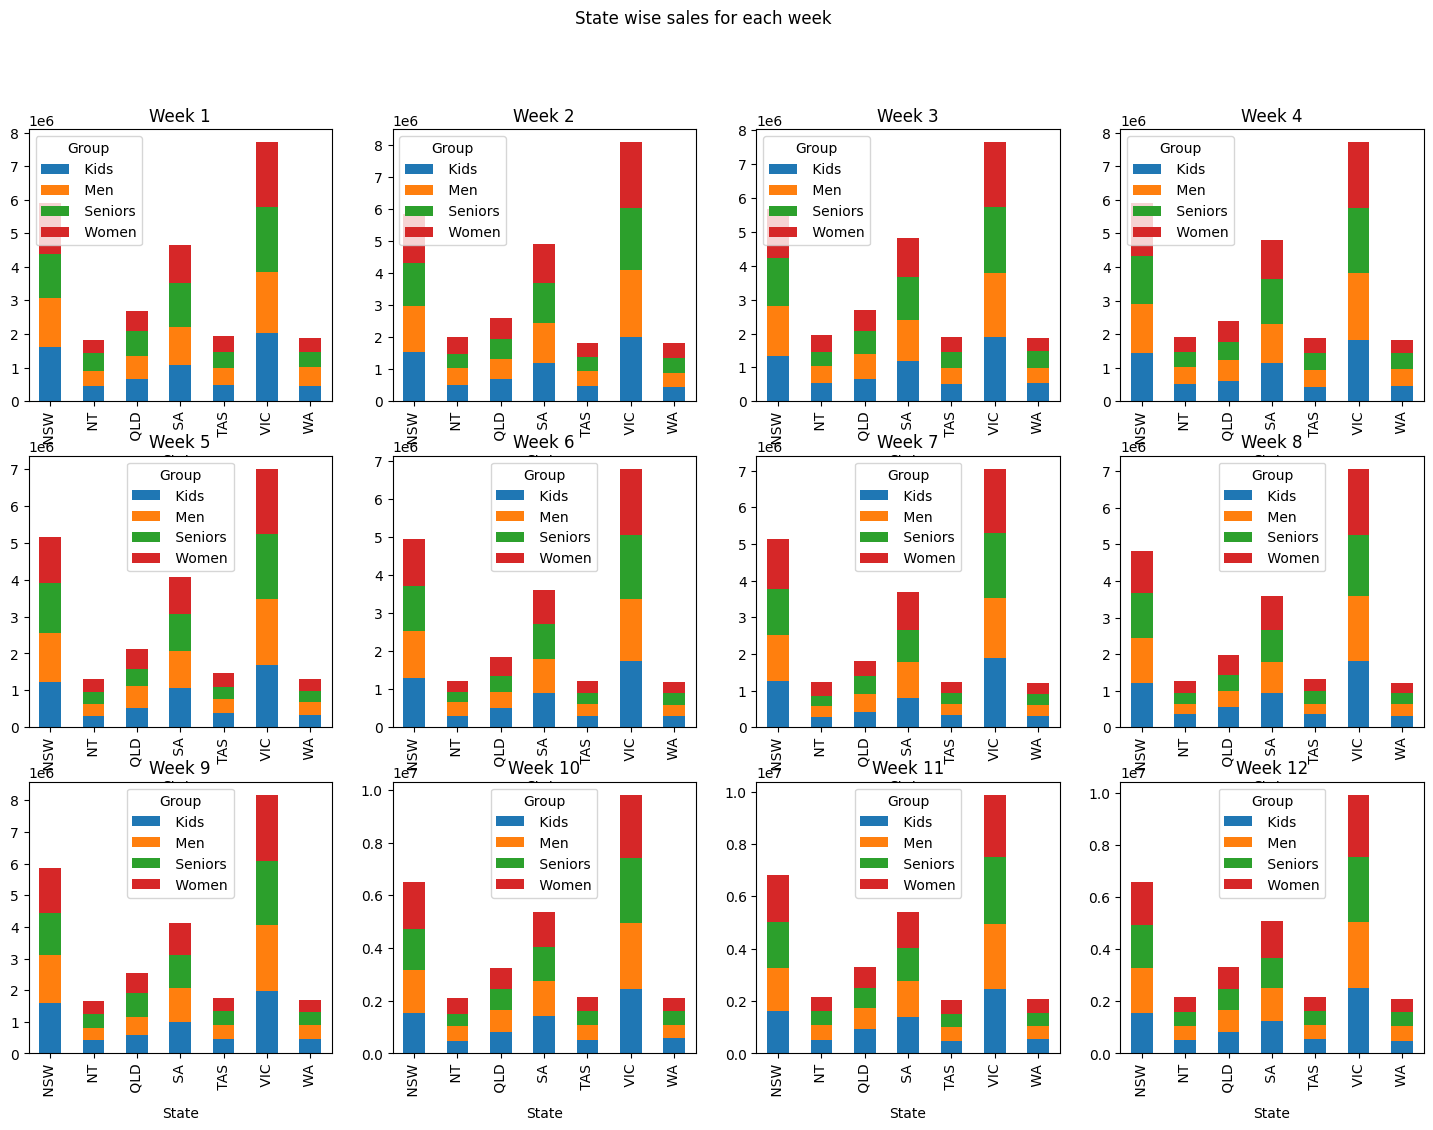

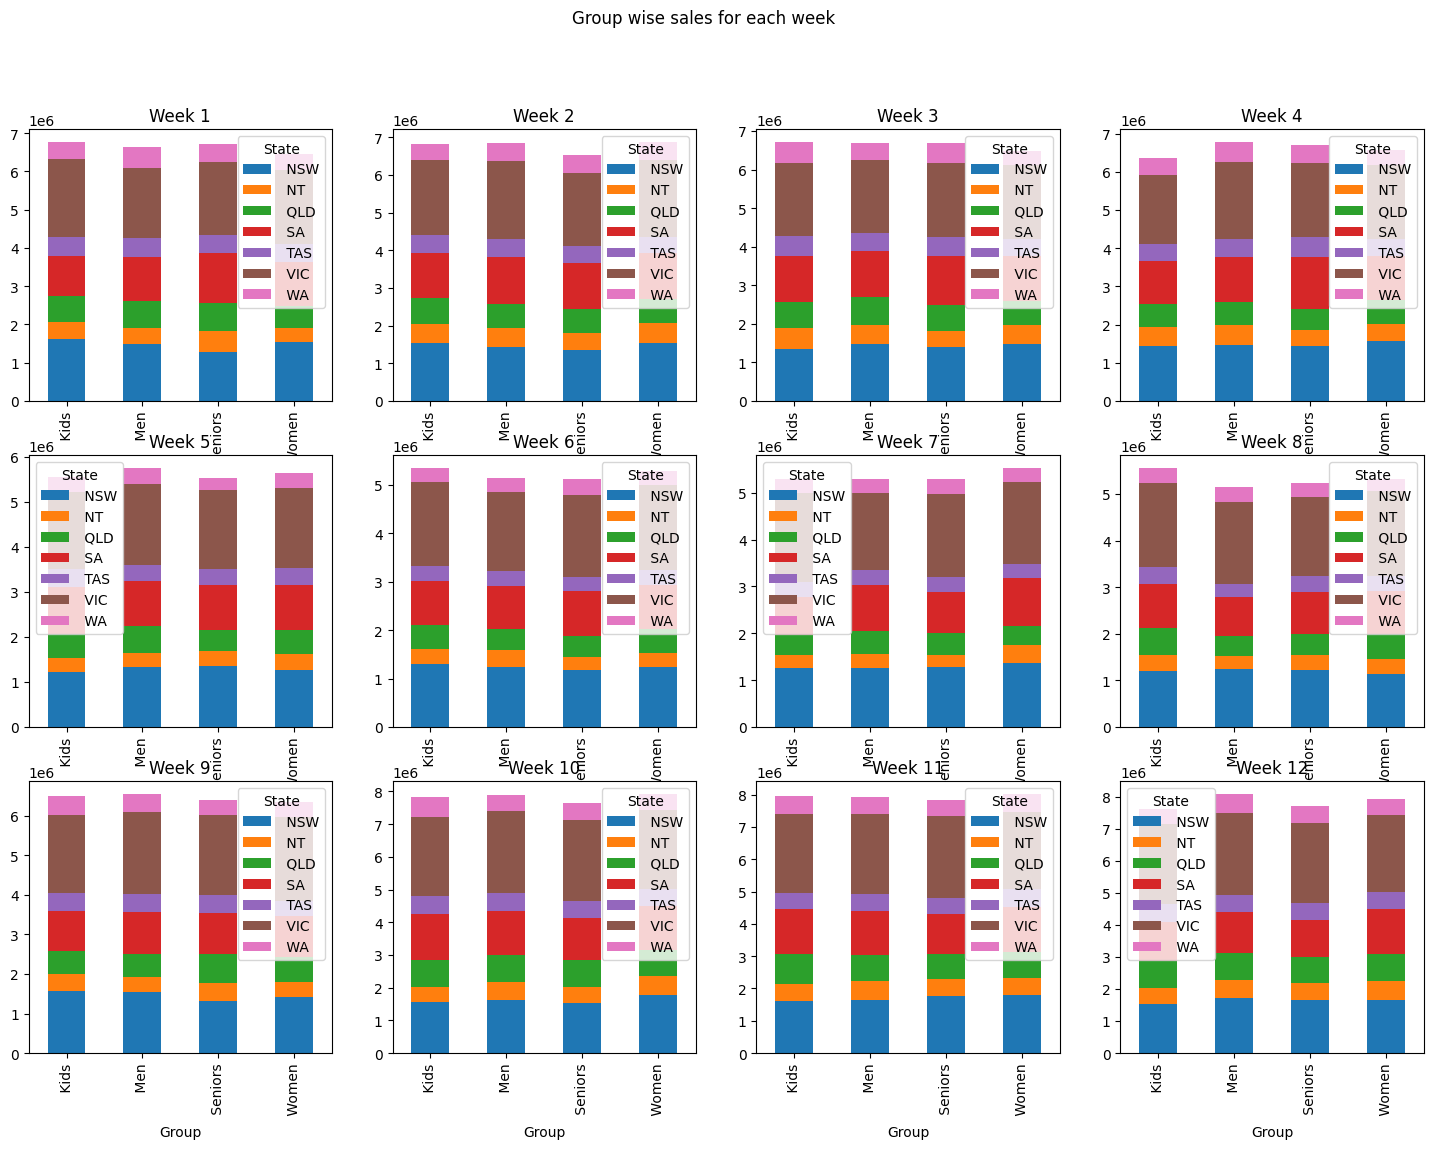

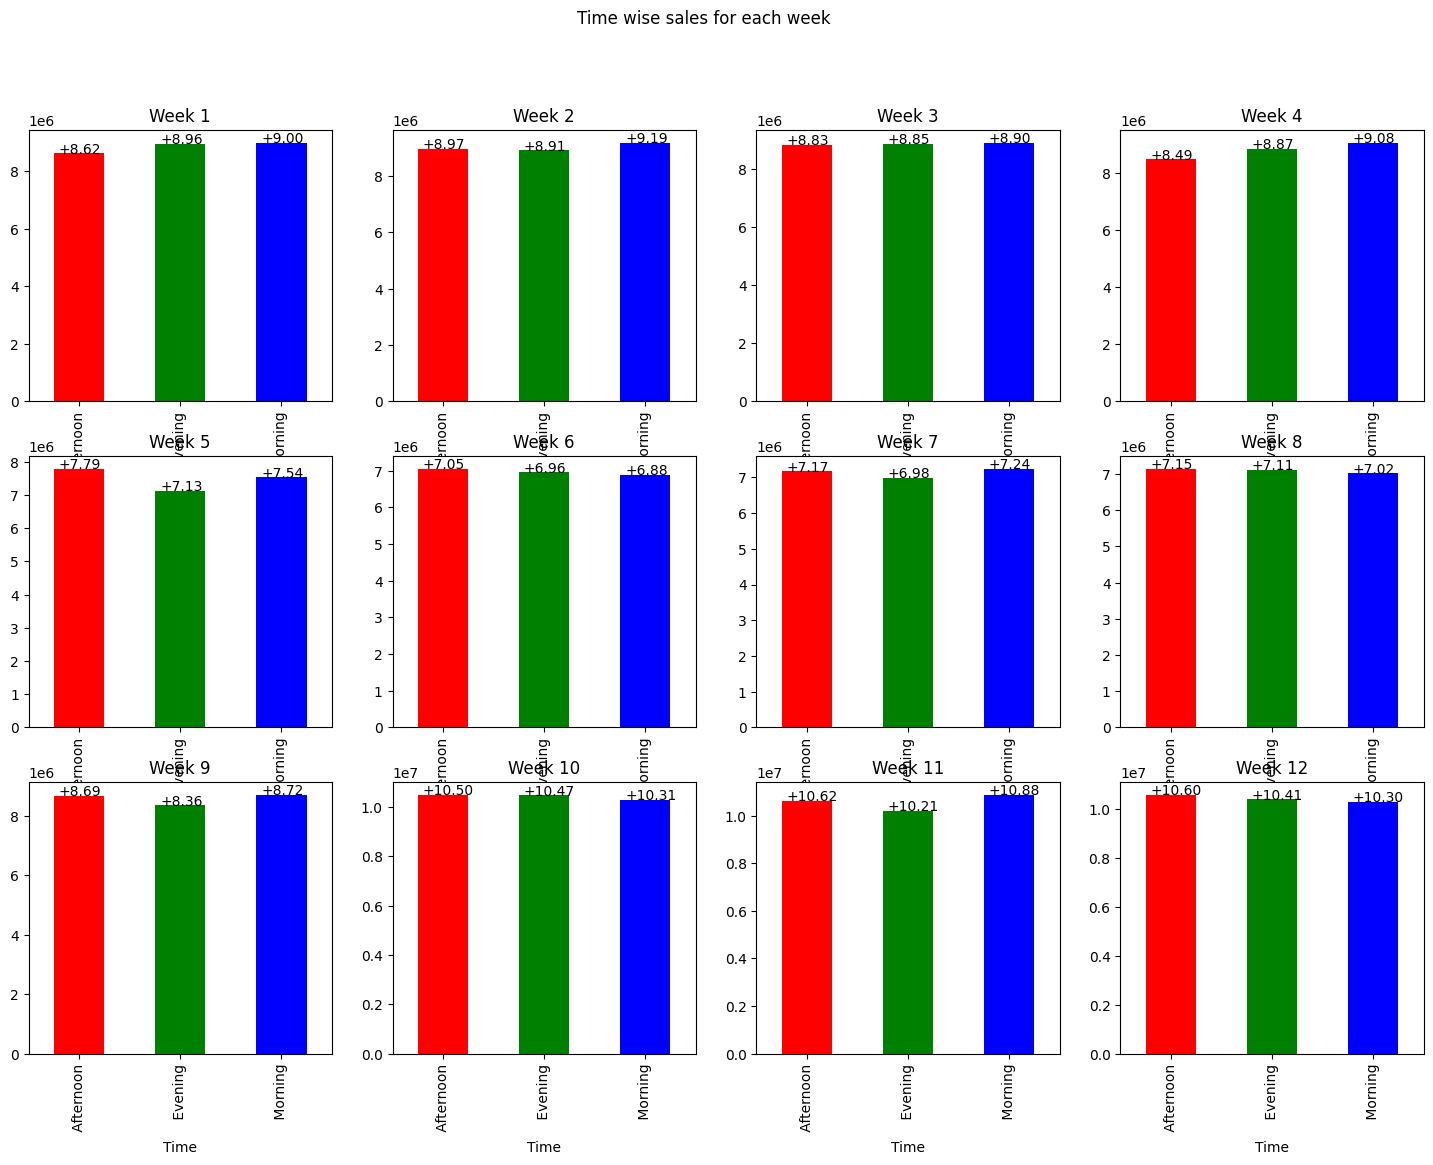

In [8]:
fig, axs = plt.subplots(nrows=3,ncols=4, figsize=(18,12))
fig.suptitle("State wise sales for each week")
for i in range(0,3):
    for j in range(0,4):
        sw_data_wk = df_wk_lst[i*4+j].groupby(['State', 'Group'])['Sales'].sum()
        sw_data_wk.unstack().plot(kind = 'bar', ax=axs[i,j], stacked = True, title=("Week "+str(i*4+j+1)))

fig, axs = plt.subplots(nrows=3,ncols=4, figsize=(18,12))
fig.suptitle("Group wise sales for each week")
for i in range(0,3):
    for j in range(0,4):
        gw_data_wk = df_wk_lst[i*4+j].groupby(['Group', 'State'])['Sales'].sum()
        gw_data_wk.unstack().plot(kind = 'bar', ax=axs[i,j], stacked = True, title=("Week "+str(i*4+j+1)))

fig, axs = plt.subplots(nrows=3,ncols=4, figsize=(18,12))
my_color = list('rgbkymc')
fig.suptitle("Time wise sales for each week")
for i in range(0,3):
    for j in range(0,4):
        tw_data_wk = df_wk_lst[i*4+j].groupby(['Time'])['Sales'].sum()
        tw_data_wk_plt = tw_data_wk.plot(kind = 'bar', ax=axs[i,j], stacked = False, title=("Week "+str(i*4+j+1)), color=my_color)
        x_offset = -0.2
        y_offset = 0.02
        for p in tw_data_wk_plt.patches:
            b = p.get_bbox()
            val = "{:+.2f}".format((b.y1 + b.y0)/1e6)        
            tw_data_wk_plt.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

### Monthly data plots

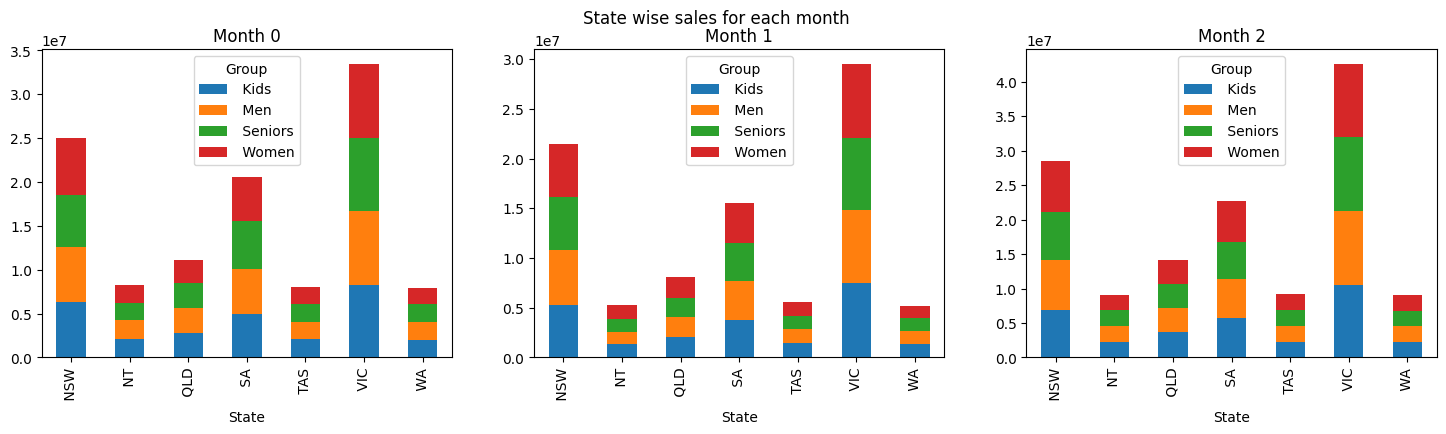

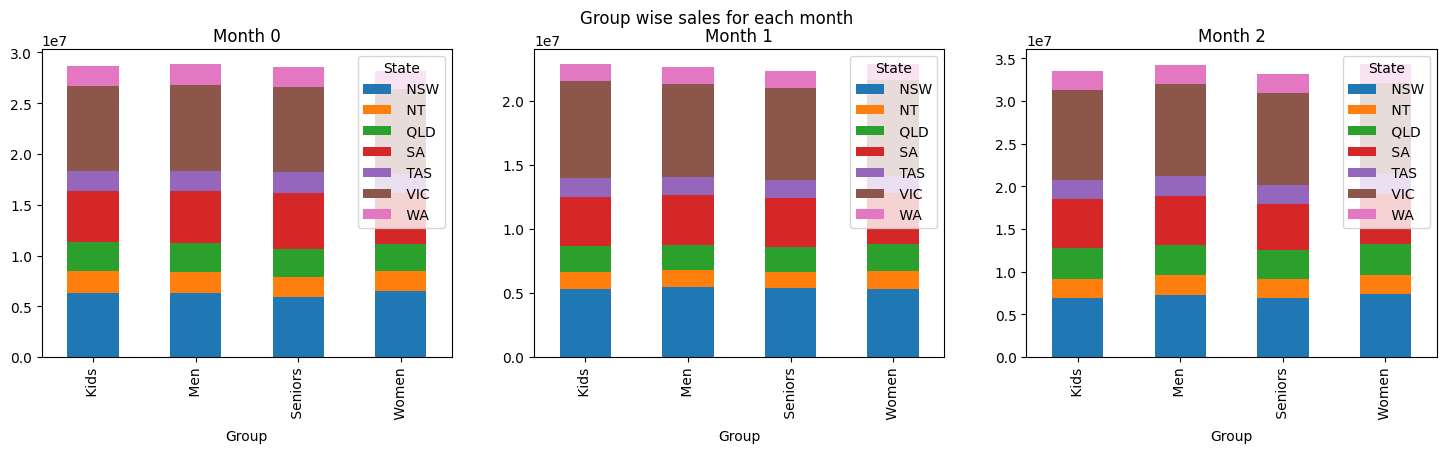

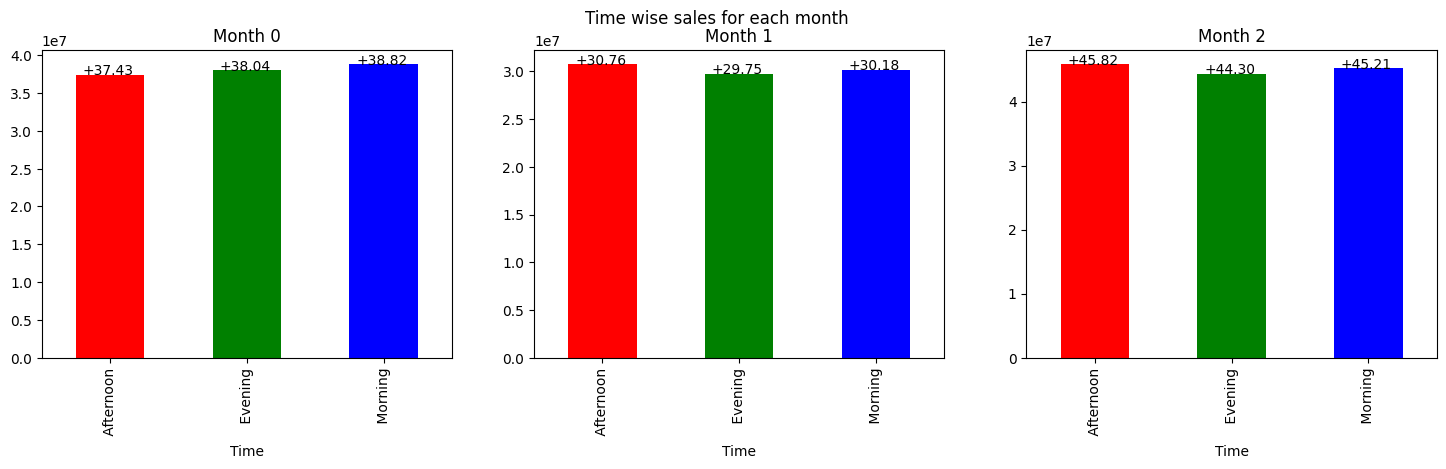

In [9]:
fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(18,4))
fig.suptitle("State wise sales for each month")
for i in range(0,3):
    sw_data_mn = df_mn_lst[i].groupby(['State', 'Group'])['Sales'].sum()
    sw_data_mn.unstack().plot(kind = 'bar', ax=axs[i], stacked = True, title=("Month "+str(i)))

fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(18,4))
fig.suptitle("Group wise sales for each month")
for i in range(0,3):
    gw_data_mn = df_mn_lst[i].groupby(['Group', 'State'])['Sales'].sum()
    gw_data_mn.unstack().plot(kind = 'bar', ax=axs[i], stacked = True, title=("Month "+str(i)))

fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(18,4))

my_color = list('rgbkymc')
fig.suptitle("Time wise sales for each month")
for i in range(0,3):
    tw_data_mn = df_mn_lst[i].groupby(['Time'])['Sales'].sum()
    tw_data_mn_plt = tw_data_mn.plot(kind = 'bar', ax=axs[i], stacked = False, title=("Month "+str(i)), color = my_color)
    x_offset = -0.2
    y_offset = 0.02
    for p in tw_data_mn_plt.patches:
        b = p.get_bbox()
        val = "{:+.2f}".format((b.y1 + b.y0)/1e6)        
        tw_data_mn_plt.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

### Data plots for the quarter

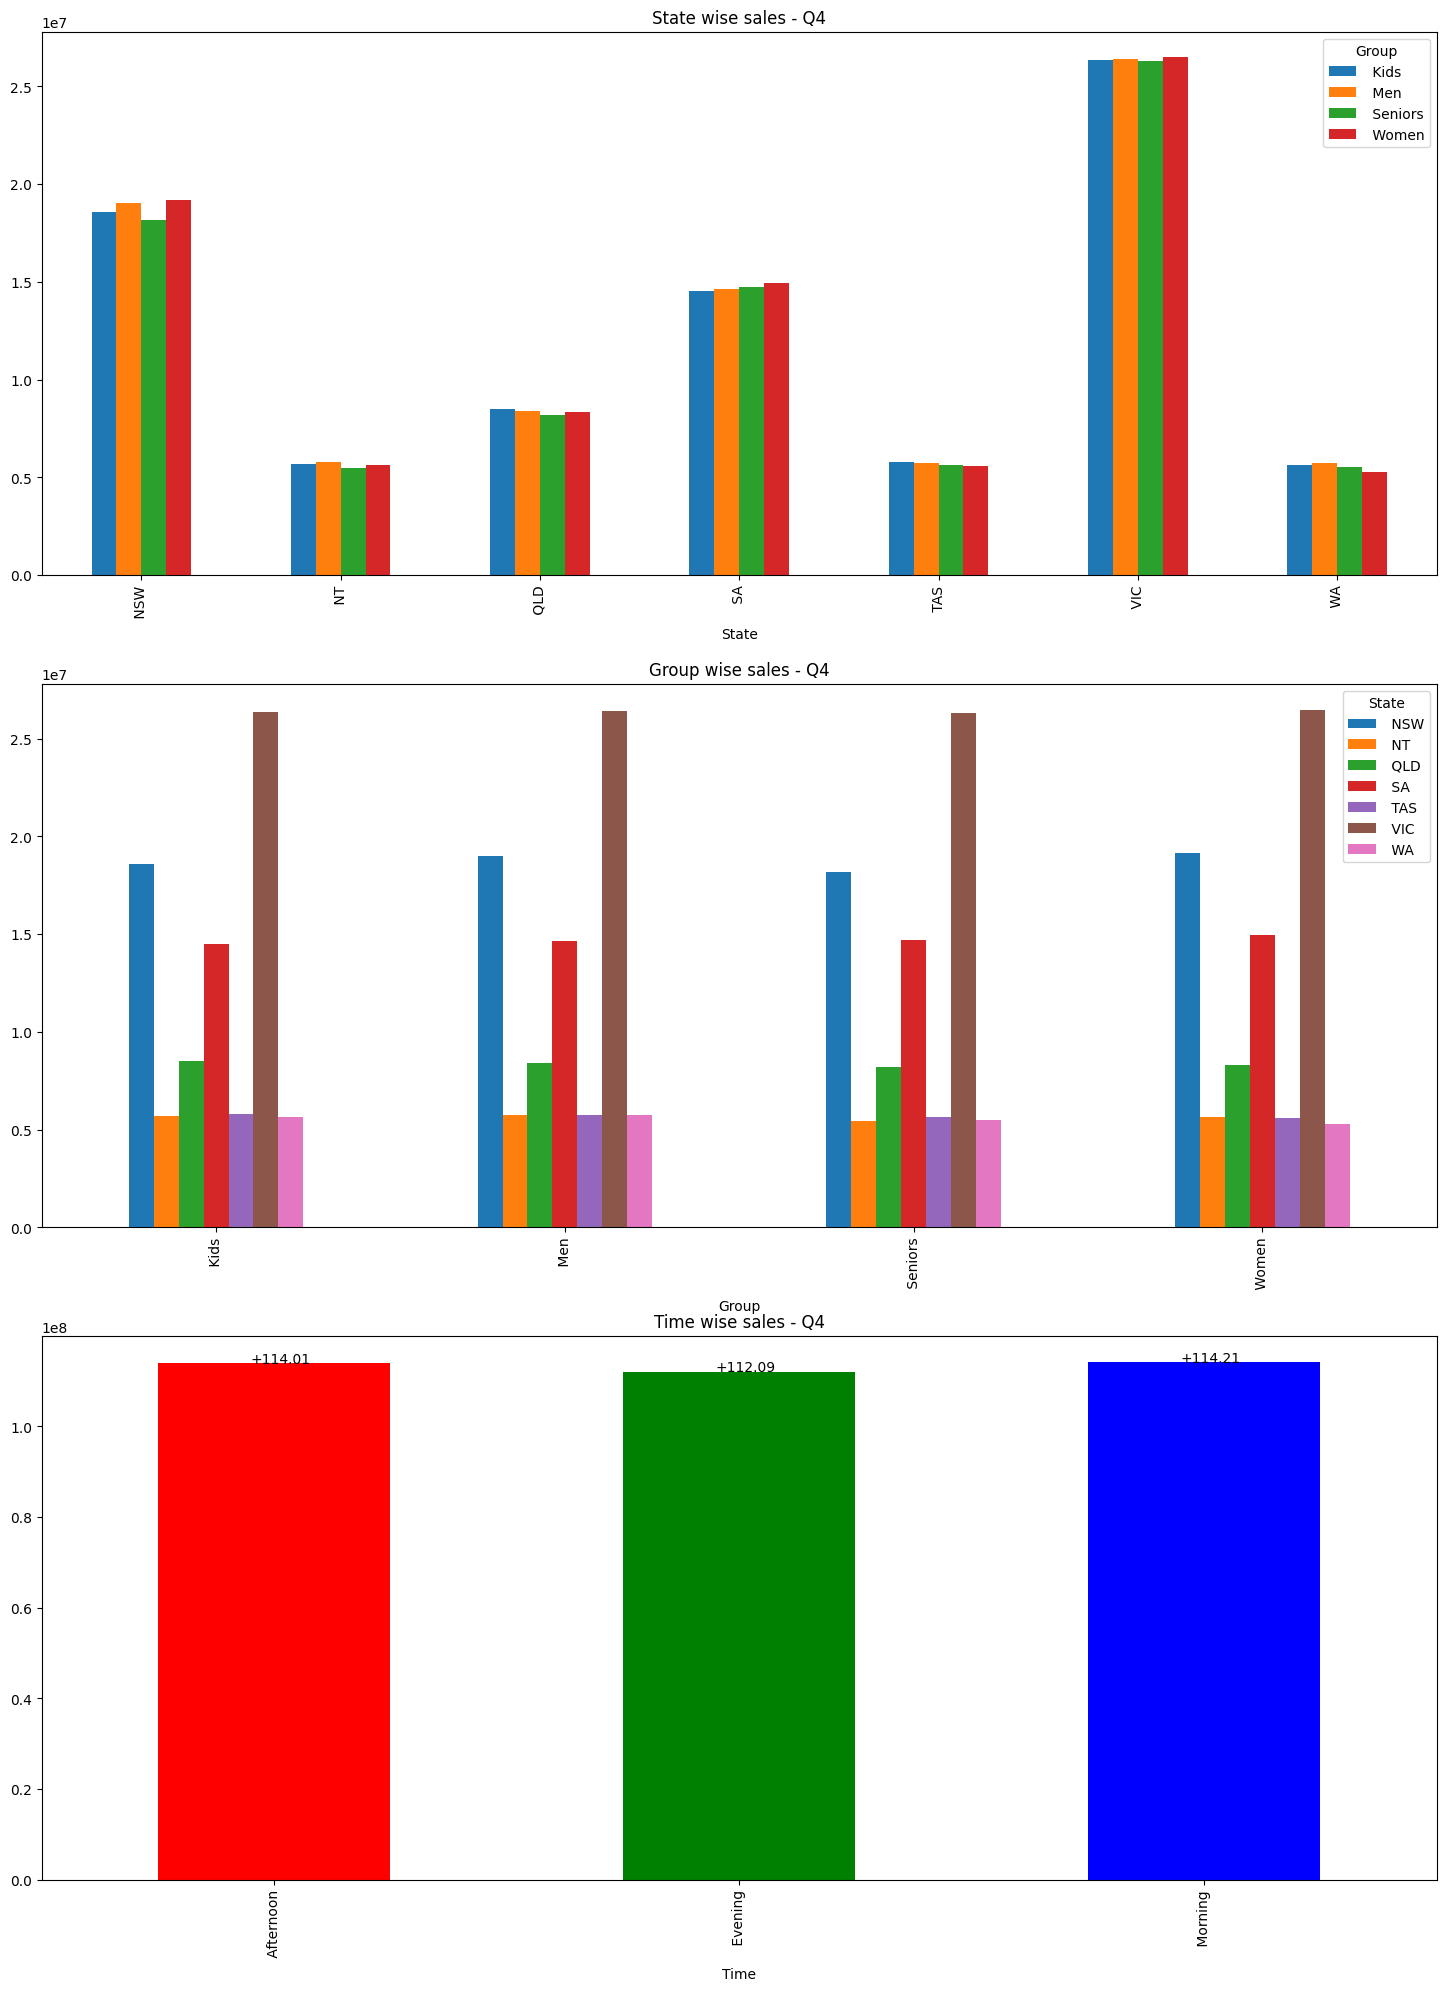

In [10]:
fig, axs = plt.subplots(nrows=3,ncols=1, figsize=(18,24))

sw_data_q4 = df.groupby(['State', 'Group'])['Sales'].sum()
gw_data_q4 = df.groupby(['Group', 'State'])['Sales'].sum()
tw_data_q4 = df.groupby(['Time'])['Sales'].sum()

my_color = list('rgbkymc')
sw_data_q4.unstack().plot(kind = 'bar', ax=axs[0], stacked = False, title="State wise sales - Q4")
gw_data_q4.unstack().plot(kind = 'bar', ax=axs[1], stacked = False, title="Group wise sales - Q4")
tw_plt = tw_data_q4.plot(kind = 'bar', ax=axs[2], stacked = False, title="Time wise sales - Q4", color=my_color)
x_offset = -0.05
y_offset = 0.02
for p in tw_plt.patches:
    b = p.get_bbox()
    val = "{:+.2f}".format((b.y1 + b.y0)/1e6)        
    tw_plt.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

## Final thoughts

1. The objective of the study is to study which states and user groups to target based on the gathered data
2. The analysis suggests the following:
    1. The states generating lower revenues are WA, NT and TAS.
    2. The group generating lowest revenue is Seniors
    3. The time of lowest sales is Evening
3. Based on these observations, it would make sense to boost marketing campaign in these areas to check if it has a positive impact on the business